# 1. Подготовка

Загрузим все нужные библиотеки, сохраним dataframe, получим общую информацию о данных и  проведем ресемплинг 

In [1]:
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import  CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse


In [2]:
data=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [3]:
display(data.head(10))
display(data.tail(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


,num_orders
datetime,
2018-08-31 14:00:00,133
2018-08-31 15:00:00,116
2018-08-31 16:00:00,197
2018-08-31 17:00:00,217
2018-08-31 18:00:00,207
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223


# 2. Анализ

Проведем небольшой анализ данных: посмотрим на распределение количества заказов в час, также посмотрим сезонную составляющую, тренд и остаток

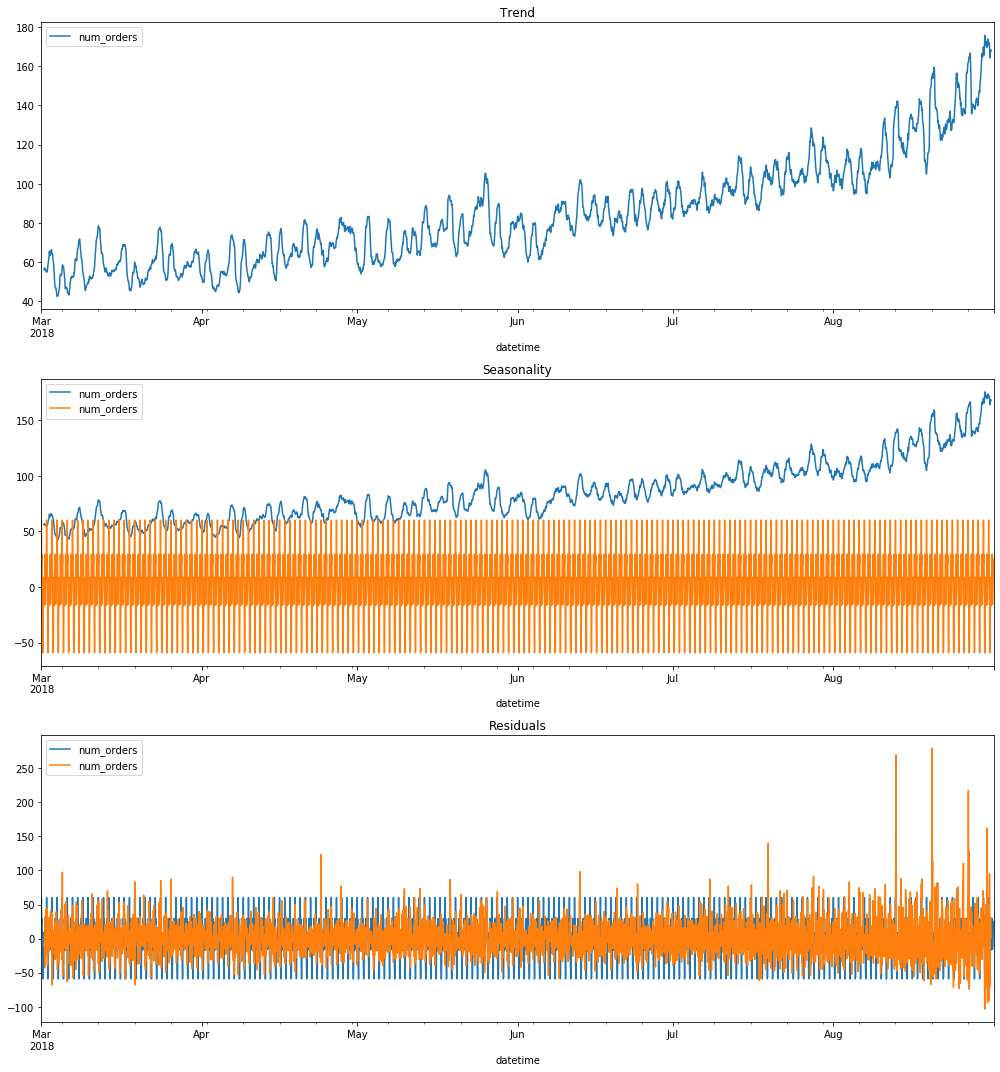

In [4]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(14, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд растет,  сезонная составляющая стационарная ( видимо данные по таксопарку крупного хаба, в небольших (региональных) аэропортах была бы нестанионарная сезонная составляющая

Есть тренд по увеличению числа заказов, сезонности нет, так как и данных мало, и желтая кривая на графике сезонности гармонически описывается в зависимости от времени( в общем - она может быть предсказана с крайне высокой точностью), а на счет непостоянства дисперсии - этот факт есть, но только в данных после августа

Создадим дополнительные фичи:  день неделии час,  добавим lag-и

In [5]:

def make_features(data, max_lag, roll_size):
 

    data['dayofweek'] = data.index.dayofweek
    data['hour']=data.index.hour
    data['rolling_mean'] = data['num_orders'].rolling(roll_size).mean()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    

   


make_features(data, 2, 2)
data=data.dropna()



In [6]:
data.info()
display(data.head(10), data.tail(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4414 entries, 2018-03-01 02:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
num_orders      4414 non-null int64
dayofweek       4414 non-null int64
hour            4414 non-null int64
rolling_mean    4414 non-null float64
lag_1           4414 non-null float64
lag_2           4414 non-null float64
dtypes: float64(3), int64(3)
memory usage: 241.4 KB


,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-01 02:00:00,71,3,2,78.0,85.0,124.0
2018-03-01 03:00:00,66,3,3,68.5,71.0,85.0
2018-03-01 04:00:00,43,3,4,54.5,66.0,71.0
2018-03-01 05:00:00,6,3,5,24.5,43.0,66.0
2018-03-01 06:00:00,12,3,6,9.0,6.0,43.0
2018-03-01 07:00:00,15,3,7,13.5,12.0,6.0
2018-03-01 08:00:00,34,3,8,24.5,15.0,12.0
2018-03-01 09:00:00,69,3,9,51.5,34.0,15.0
2018-03-01 10:00:00,64,3,10,66.5,69.0,34.0


,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-08-31 14:00:00,133,4,14,149.5,166.0,136.0
2018-08-31 15:00:00,116,4,15,124.5,133.0,166.0
2018-08-31 16:00:00,197,4,16,156.5,116.0,133.0
2018-08-31 17:00:00,217,4,17,207.0,197.0,116.0
2018-08-31 18:00:00,207,4,18,212.0,217.0,197.0
2018-08-31 19:00:00,136,4,19,171.5,207.0,217.0
2018-08-31 20:00:00,154,4,20,145.0,136.0,207.0
2018-08-31 21:00:00,159,4,21,156.5,154.0,136.0
2018-08-31 22:00:00,223,4,22,191.0,159.0,154.0


Год, месяц и день отпадают, данных мало. Но день недели в сочетании с часом могут влиять, так как количество пассажиров в будние и выходные дни может отличаться, как и количество пассажиров в пять утра и в пять вечера. Еще можно ввести свой аналог градиента: добавить в df данные о разнице в количестве заказов за последний час-два. К примеру: можно увидеть момент, когда утром люди едут на работу и по своим делам - будет заметно увеличение числа заказов

Разобьем данные на train,valid и test, выделим фичи и целевые значения

In [7]:
train, not_train = train_test_split(data, shuffle=False, test_size=0.2)
valid, test= train_test_split(not_train, shuffle=False, test_size=0.5)
features_train=train.drop(columns=['num_orders'])
target_train=train['num_orders']
features_valid=valid.drop(columns=['num_orders'])
target_valid=valid['num_orders']

features_test=test.drop(columns=['num_orders'])
target_test=test['num_orders']

In [8]:
#создадим df, в котором будем сохранять предсказания моделей на test-е
columns=['test']
result=pd.DataFrame( columns=columns)
result['test']=target_test

# 3. Обучение

Немного поленимся и в начале не будем кастомить модели, посмотрим какие значения на test-е и train-е они дадут "из коробки". Да, для того чтобы не учить одну и туже модель несколько раз, сразу будем тестить( вдруг модели будут обучаться длительное время)

In [9]:
def model_fit(our_model):
    model=our_model
    model.fit(features_train,target_train)
    train_pred=model.predict(features_train)
    valid_pred=model.predict(features_valid)
    test_pred=model.predict(features_test)
    
    
    
    print("RMAE обучающей выборки:", mse(target_train, train_pred )**0.5)
    print("RMAE валидационной выборки:", mse(target_valid, valid_pred)**0.5)
    print("RMAE тестовой выборки:", mse(target_test, test_pred)**0.5)
    return test_pred
    
    
    

In [10]:
%%time
#Линейная регрессия 
result['test_lin']=model_fit(LinearRegression())

RMAE обучающей выборки: 2.5114517230782208e-14
RMAE валидационной выборки: 4.45070157729759e-14
RMAE тестовой выборки: 6.601122651572405e-14
CPU times: user 29.2 ms, sys: 39.7 ms, total: 68.9 ms
Wall time: 16.5 ms


In [11]:
%%time
#СatBoost
result['test_cat']=model_fit(CatBoostRegressor(silent=True))

RMAE обучающей выборки: 0.8193429380416162
RMAE валидационной выборки: 16.997223840896734
RMAE тестовой выборки: 33.79073325486074
CPU times: user 24.9 s, sys: 3.64 s, total: 28.5 s
Wall time: 29.9 s


In [12]:
%%time
result['test_lgb']=model_fit(LGBMRegressor())

RMAE обучающей выборки: 2.6789407374678973
RMAE валидационной выборки: 17.59272528279714
RMAE тестовой выборки: 36.37258703492233
CPU times: user 12.4 s, sys: 0 ns, total: 12.4 s
Wall time: 12.4 s


В общем-то все модели преодолели необходимый порог значения RMSE на train-е, наилучшей выглядит модель LinearRegression, у нее наименьшее значение RMSE на test-e, который иммитирует реальную работу. Также посмотрим график зависимостей между test и предсказаниями моделей на фичах теста

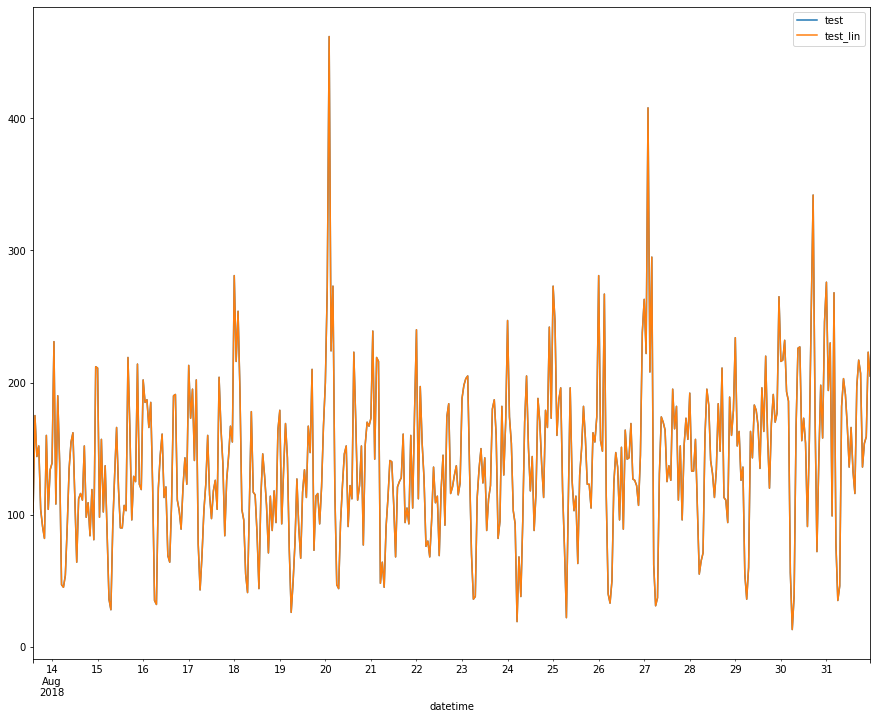

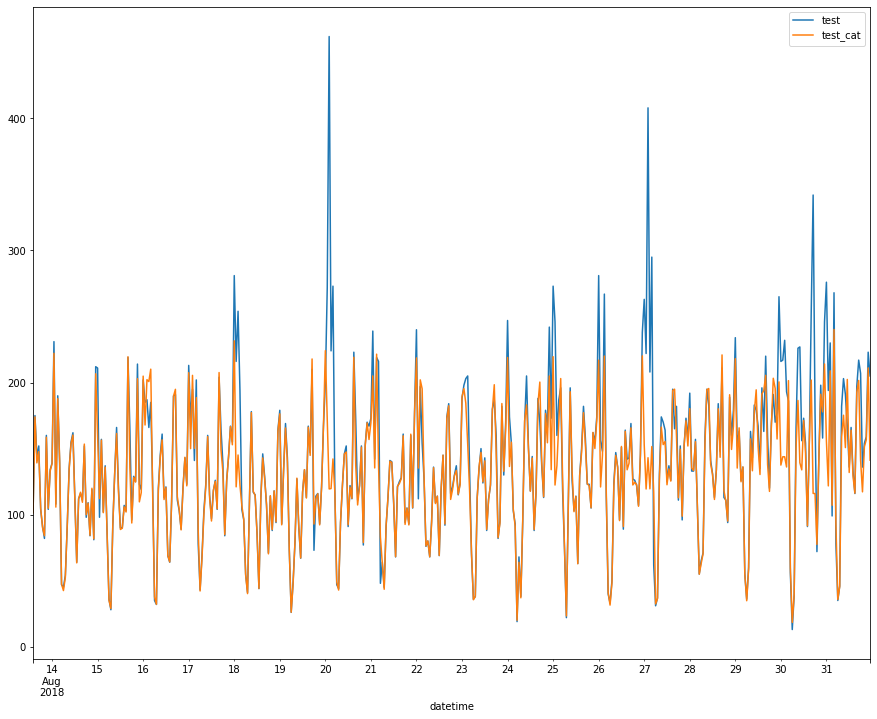

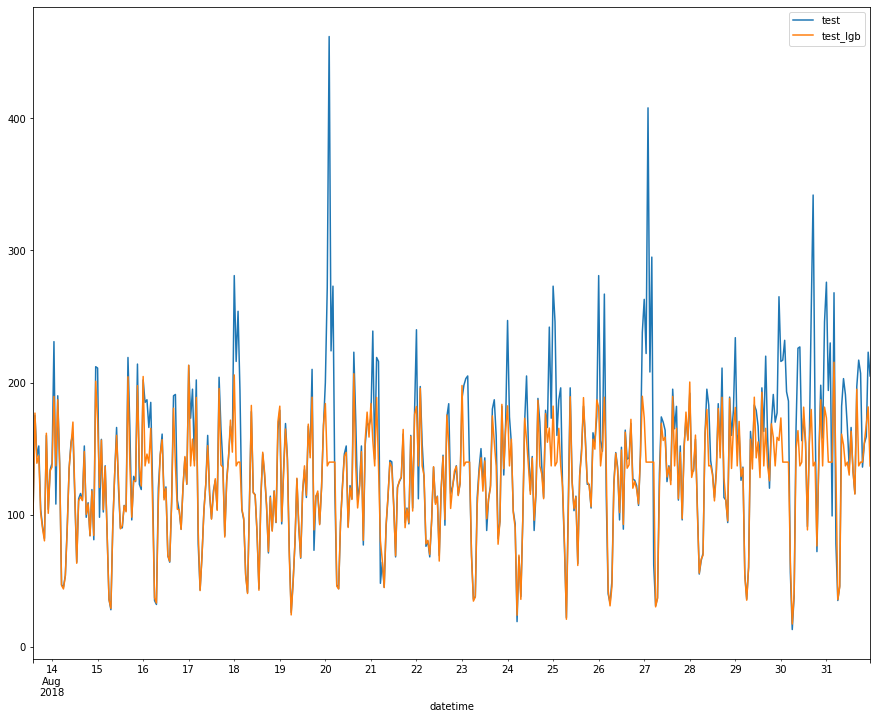

In [17]:
for column in ['test_lin','test_cat','test_lgb']:
    res=result[['test', column]]
    res.plot(figsize=(15,12))
    plt.show()

Теперь понятно, почему линейная регрессия дает такие высокие результаты, она научилась крайне хорошо предсказывать данные. Тогда как catboost и lgbm находят закономерности там, где их нет